<a href="https://colab.research.google.com/github/ekourkchi/Weather_research/blob/master/GPR_PSO_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing packages


In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import pandas as pd
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
data preparation
We generate the first 3 main principal components that capture the most useful information of the data. P1, P2 and P3 are not correalted with each other while they are epressed as the linear cominination of the available featurdes, i.e. ET0, VPD, Rn and T (air temperature)

**Note:** Make sure that the data file is addressed correctly and it's already avaialble in your Google drive.

In [37]:

dataFile = 'Changde.xlsx'  
# dataFile = 'Hailisu.xlsx'  
# dataFile = 'Lancang.xlsx'  
# dataFile = 'Miyun.xlsx'  
# dataFile = 'Nanmulin.xlsx'  
# dataFile = 'Qiemo.xlsx'

data = pd.read_excel('/content/drive/My Drive/'+ dataFile)

In [3]:
# revising the column names
for col in data.columns:
  newcol = col.split("(")[0].strip()
  data.rename(columns={col:newcol}, inplace=True)

# setting up the index of the data frame
data.set_index("TIMESTAMP", inplace=True)

# resample data daily, forward linear interpolation to fill the missing values
data.resample('1d').mean()
data = data.interpolate(method='linear', limit_direction='forward', axis=0)

## Optional:
## Generating the first three principal (P1, P2, P3) components basesd on ET0, VPD, Rn and T.
myData = data[["ET0", "VPD", "Rn", "T"]].ffill()
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(myData)
pca_data = PCA().fit_transform(z_data);
pca_trafo = PCA().fit(z_data);
data["P1"] = pca_data[:,0]
data["P2"] = pca_data[:,1]
data["P3"] = pca_data[:,3]

# displaying the first couple rows of the data table
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3
TIMESTAMP,,,,,,,,,,,,,,,
1990-01-01,1.0,0.5,6.5,8.2,86.0,3.5,10.7,3.917056,0.133488,0.066737,0.067364,0.832234,-2.186561,0.139099,-0.025176
1990-01-02,2.0,2.8,5.7,6.9,76.0,4.5,7.6,3.304720,0.217895,0.063561,0.067364,1.119791,-2.121484,0.395804,0.126834
1990-01-03,3.0,1.0,6.1,6.9,74.0,4.5,8.2,3.388471,0.242432,0.065133,0.067364,0.918324,-2.125727,0.402496,0.002293
1990-01-04,4.0,0.3,6.3,8.1,85.0,3.2,8.3,3.358427,0.142941,0.065931,0.067364,0.710937,-2.290894,0.208461,-0.022489
1990-01-05,5.0,1.0,8.0,8.9,84.0,3.4,12.2,4.420837,0.169524,0.073061,0.067364,1.030776,-1.943976,0.085135,-0.023855


# Staging some data for ML modeling


Generating train and test data sets.
For the sake of speed, we use use a fraction of data for evaluation of our algorithm. Later to get the final results, we use the entire data set.

Text(0.5, 0, 'Time')

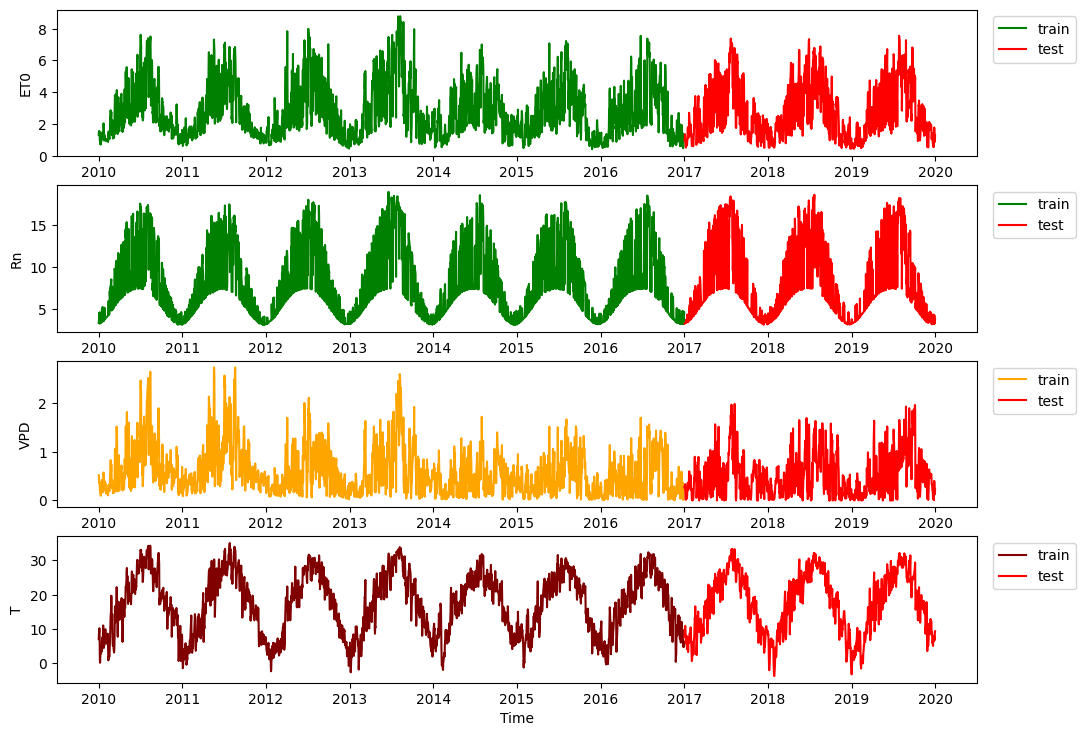

In [4]:
fig = py.figure(figsize=(10,15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(7,1) ; p=0

# training: 2010-2017
subData = data.loc["2010":"2016-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"].ffill()
z = subData["Rn"].ffill()
v = subData["VPD"].ffill()
w = subData["T"].ffill()
tm = subData["Delta"].ffill()
tx = subData["TA_max"].ffill()

# testing: 2013 onward
subData_test = data.loc["2017":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"].ffill()
z_test = subData_test["Rn"].ffill()
v_test = subData_test["VPD"].ffill()
w_test = subData_test["T"].ffill()
tm_test = subData_test["Delta"].ffill()
tx_test = subData_test["TA_max"].ffill()

# top plot 
p = 0

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, y, color='green', label="train")
ax.plot(x_test, y_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("ET0")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, z, color='green', label="train")
ax.plot(x_test, z_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("Rn")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, v, color='orange', label="train")
ax.plot(x_test, v_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("VPD")

ax = plt.subplot(gs[p]) ; p+=1
ax.plot(x, w, color='maroon', label="train")
ax.plot(x_test, w_test, color='red', label="test")
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_ylabel("T")


ax.set_xlabel("Time")

In [5]:
def dataPrepare2(y, n = 3, d = 1):
  '''
  Generating discrete data points out of the given series

  y: main signal, e.g. ET0
  z, v, w: auxiliary signals (set these to zero (e.g z=y*0) if not interested)
  n: the number of previous data points that are used for forcasting
  d: the number of days ahead for forecasting

  output: feature matrix XS, and target values ys
  '''

  N = len(y)
  dd = d - 1

  XS = np.zeros((N-n-dd, n))
  ys = np.zeros(N-n-dd)

  for i in range(0, N-n-dd):
    XS[i,:n] = y[i:i+n]  
   
    ys[i] = y[i+n+dd]
  # 
  return XS, ys

In [6]:
from sklearn.preprocessing import MinMaxScaler


lag = 16
d = 1

def scaleIT(y, y_test):

  y_train_lag = y[-lag:]


  new_test_series =  pd.concat([y_train_lag, y_test])

  sc = MinMaxScaler(feature_range=(0,1))
  ys = sc.fit_transform(y.values.reshape(-1,1)).reshape(-1)
  ys_test = sc.transform(new_test_series.values.reshape(-1,1)).reshape(-1)

  return ys, ys_test, sc

In [7]:
# y: ET0 
# z: P1 (the first principal component)
# v: T (temperature)
# w: VPD

ys, ys_test, scaler = scaleIT(y, y_test)
ws, ws_test, _ = scaleIT(w, w_test)
zs, zs_test, _ = scaleIT(z, z_test)
vs, vs_test, _ = scaleIT(v, v_test)

txs, txs_test, _ = scaleIT(tx, tx_test)
tms, tms_test, _ = scaleIT(tm, tm_test)

TXS_train, _ = dataPrepare2(txs, n=lag, d=d)
TXS_test, _ = dataPrepare2(txs_test, n=lag, d=d)

TMS_train, _ = dataPrepare2(tms, n=lag, d=d)
TMS_test, _ = dataPrepare2(tms_test, n=lag, d=d)

VS_train, _ = dataPrepare2(vs, n=lag, d=d)
VS_test, _ = dataPrepare2(vs_test, n=lag, d=d)

WS_train, _ = dataPrepare2(ws, n=lag, d=d)
WS_test, _ = dataPrepare2(ws_test, n=lag, d=d)

ZS_train, _ = dataPrepare2(zs, n=lag, d=d)
ZS_test, _ = dataPrepare2(zs_test, n=lag, d=d)


XS_train, ys_train = dataPrepare2(ys, n=lag, d=d)
XS_test, ys_test = dataPrepare2(ys_test, n=lag, d=d)



print(XS_train.shape, ys_train.shape)
print(XS_test.shape, ys_test.shape)

(2541, 16) (2541,)
(1096, 16) (1096,)


In [8]:
# Reshaping X_train for efficient modeling
XS_train = np.reshape(XS_train, (XS_train.shape[0],XS_train.shape[1], 1))
WS_train = np.reshape(WS_train, (WS_train.shape[0],WS_train.shape[1], 1))
ZS_train = np.reshape(ZS_train, (ZS_train.shape[0],ZS_train.shape[1], 1))
VS_train = np.reshape(VS_train, (VS_train.shape[0],VS_train.shape[1], 1))

TXS_train = np.reshape(TXS_train, (TXS_train.shape[0],TXS_train.shape[1], 1))
TMS_train = np.reshape(TMS_train, (TMS_train.shape[0],TMS_train.shape[1], 1))


XX = np.zeros((XS_train.shape[0],XS_train.shape[1], 6))

XX[:,:,0] = XS_train[:,:,0]
XX[:,:,1] = WS_train[:,:,0]
XX[:,:,2] = ZS_train[:,:,0]
XX[:,:,3] = VS_train[:,:,0]
# XX[:,:,4] = TXS_train[:,:,0]
# XX[:,:,5] = TMS_train[:,:,0]


XS_train = XX

In [9]:
XS_test = np.reshape(XS_test, (XS_test.shape[0],XS_test.shape[1], 1))
WS_test = np.reshape(WS_test, (WS_test.shape[0],WS_test.shape[1], 1))
ZS_test = np.reshape(ZS_test, (ZS_test.shape[0],ZS_test.shape[1], 1))
VS_test = np.reshape(VS_test, (VS_test.shape[0],VS_test.shape[1], 1))

TXS_test = np.reshape(TXS_test, (TXS_test.shape[0],TXS_test.shape[1], 1))
TMS_test = np.reshape(TMS_test, (TMS_test.shape[0],TMS_test.shape[1], 1))


XX = np.zeros((XS_test.shape[0],XS_test.shape[1], 6))

XX[:,:,0] = XS_test[:,:,0]
XX[:,:,1] = WS_test[:,:,0]
XX[:,:,2] = ZS_test[:,:,0]
XX[:,:,3] = VS_test[:,:,0]
# XX[:,:,4] = TXS_test[:,:,0]
# XX[:,:,5] = TMS_test[:,:,0]


XS_test = XX

In [10]:
XS_train.shape

(2541, 16, 6)

In [11]:
# %tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

def Model():
  regressor = Sequential()

  # First LSTM layer with Dropout regularisation
  # regressor.add(LSTM(units=64, return_sequences=True, input_shape=(lag,6)))   #  (XS_train.shape[1],1)
  # regressor.add(Dropout(0.2))

  # regressor.add(LSTM(units=64, return_sequences=True))
                    
  # Second LSTM layer
  # regressor.add(LSTM(units=64, input_shape=(lag,6), return_sequences=True))

  # regressor.add(LSTM(units=64, return_sequences=True))

  # regressor.add(LSTM(units=64, return_sequences=True))

  regressor.add(LSTM(units=16))

  # regressor.add(Dense(units=16))

  # regressor.add(Dense(units=8))

  # The output layer
  regressor.add(Dense(units=1))

  # Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)

  regressor.compile(optimizer='rmsprop', loss='mse')

  return regressor

# 

In [12]:
def Trainer(XS_train, ys_train, n_epochs = 10):
  
  regressor = Model()
  regressor.fit(XS_train,ys_train, epochs=n_epochs, batch_size=32, validation_split=0.1, shuffle=True, verbose=False)
  # regressor.fit(XS_train[-100:,:,:],ys_train[-100:], epochs=10, batch_size=16, validation_split=0.1, shuffle=False, verbose=False)

  return regressor

In [13]:
n_epochs = 30
regressor = Trainer(XS_train, ys_train, n_epochs = n_epochs)

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1472      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


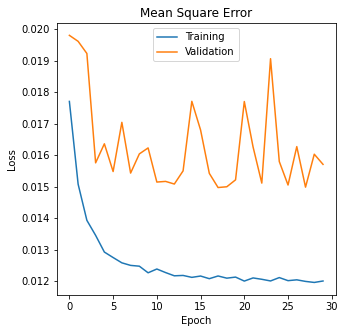

In [14]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(5,5))
    ax.plot(np.arange(n_epochs), loss, label='Training')
    ax.plot(np.arange(n_epochs), val_loss, label='Validation')
    ax.set_title('Mean Square Error')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

###plot the training history
# for key in regressor.history.history:
#   print(key)

plot_model_history(regressor.history)

In [15]:
def metrics(y1, y2):
  '''
  y1 and y2 are two series of the same size

  This function outputs the MAE, RMSE and R^2 
  of the cross evaluated series.

  '''
  y1 = y1.reshape(-1)
  y2 = y2.reshape(-1)
  RMSE = np.sqrt(np.mean((y1-y2)**2))
  MAE = np.mean(np.abs(y1-y2))
  R2 = r2_score(y1, y2)
  print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
########################################

In [16]:
predicted = regressor.predict(XS_test)

print("Test set: ")

metrics(scaler.inverse_transform(ys_test.reshape(-1,1)).reshape(-1), scaler.inverse_transform(predicted.reshape(-1,1)).reshape(-1))


Test set: 
MAE: 0.74  RMSE: 0.97  R^2: 0.68


Text(0.5, 1.0, '1 day ahead predictions (Test)')

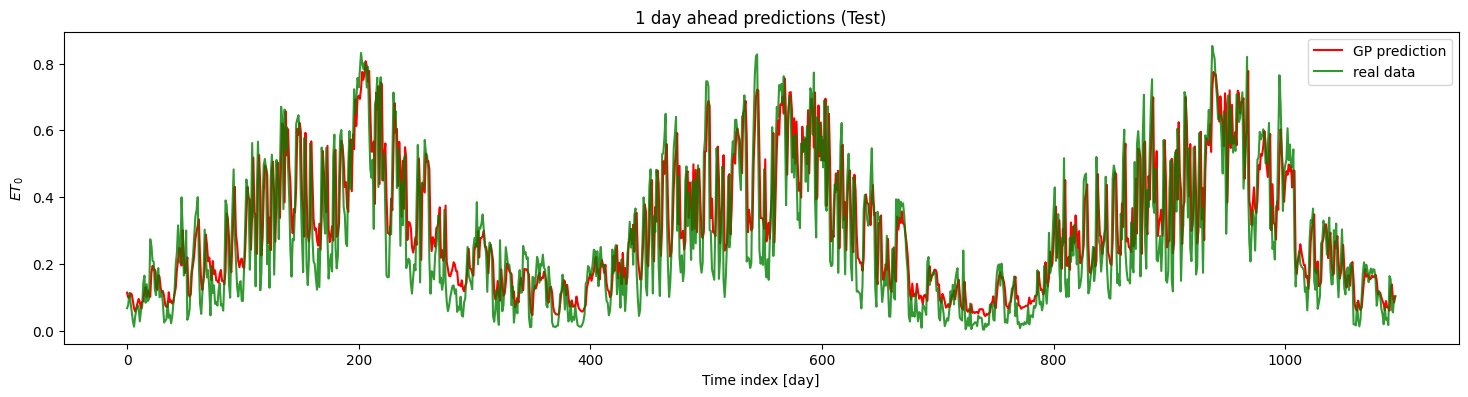

In [17]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

# ax.plot(gp_yp, 'r.-',  alpha=1)
# ax.plot(ys2, 'g.-', alpha=0.8)

ax.plot(predicted, 'r-',  alpha=1, label='GP prediction')
ax.plot(ys_test, 'g-', alpha=0.8, label='real data')


ax.legend()
# ax.set_xlim(0,1000)
ax.set_ylabel("$ET_0$")
ax.set_xlabel("Time index [day]")
ax.set_title("1 day ahead predictions (Test)")

Text(0.5, 1.0, 'Hailisu')

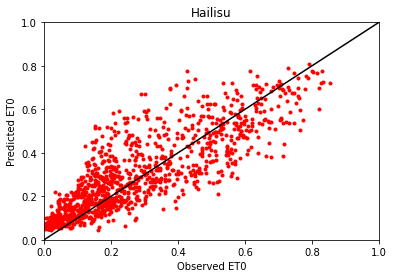

In [18]:
plt.plot(ys_test, predicted, 'r.')

plt.plot([0, 8], [0, 8], 'k-')

plt.xlabel("Observed ET0")
plt.ylabel("Predicted ET0")

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Hailisu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


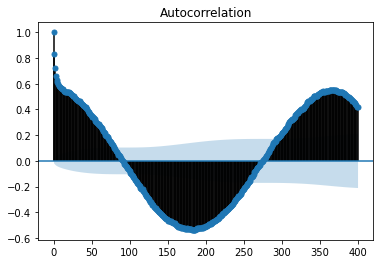

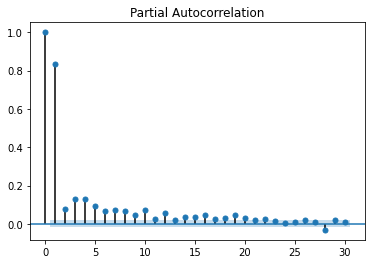

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = data["ET0"].ffill().bfill()#.fillna(1)

plot_acf(y, lags=400) ; plt.show()
plot_pacf(y, lags=30) ; plt.show()

In [20]:
data.head()

,DOY,U,T,ea（hpa）,RH,TA_min,TA_max,Rn,VPD,Delta,gamma,ET0,P1,P2,P3
TIMESTAMP,,,,,,,,,,,,,,,
1990-01-01,1.0,0.5,6.5,8.2,86.0,3.5,10.7,3.917056,0.133488,0.066737,0.067364,0.832234,-2.186561,0.139099,-0.025176
1990-01-02,2.0,2.8,5.7,6.9,76.0,4.5,7.6,3.304720,0.217895,0.063561,0.067364,1.119791,-2.121484,0.395804,0.126834
1990-01-03,3.0,1.0,6.1,6.9,74.0,4.5,8.2,3.388471,0.242432,0.065133,0.067364,0.918324,-2.125727,0.402496,0.002293
1990-01-04,4.0,0.3,6.3,8.1,85.0,3.2,8.3,3.358427,0.142941,0.065931,0.067364,0.710937,-2.290894,0.208461,-0.022489
1990-01-05,5.0,1.0,8.0,8.9,84.0,3.4,12.2,4.420837,0.169524,0.073061,0.067364,1.030776,-1.943976,0.085135,-0.023855


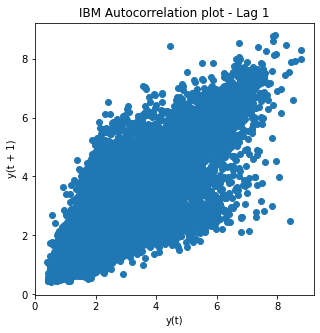

In [21]:
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))

lag_plot(data['ET0'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 1');

In [22]:
train_data = data.loc["2010":"2016-12-31"]
test_data  = data.loc["2017":]

train_series = train_data['ET0']
test_series = test_data['ET0']
train_series.shape, test_series.shape

((2557,), (1096,))

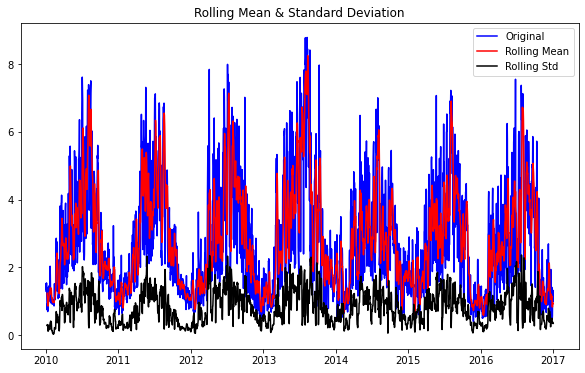

In [23]:
window = 7
train_series = train_data['ET0']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

In [24]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)

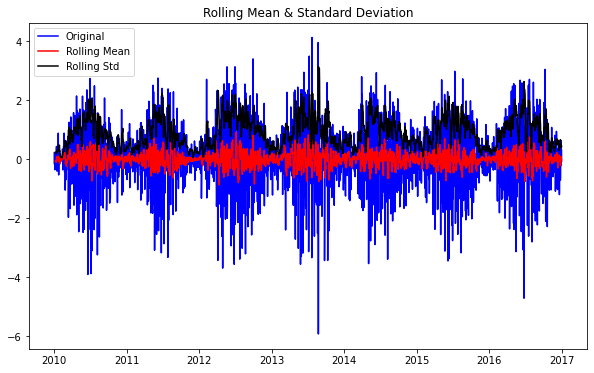

In [25]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');

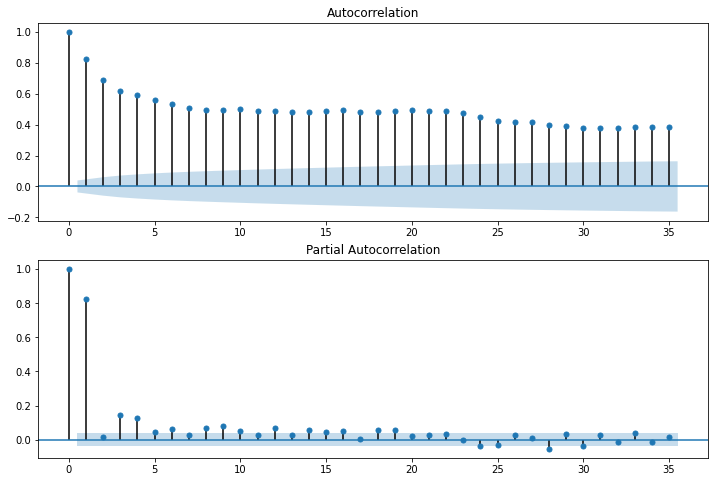

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

In [27]:
test_series = test_data['ET0']
test_diff = test_series.diff(1)
test_diff = test_diff.dropna(inplace = False)

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [29]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    model = ARIMA(history, order=(10,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit(disp=0) # fit the model
    # END_CODE_HERE

    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

Test Series Point: 0	Predicted=0.03828600095398202, Expected=0.0870041272494263
Test Series Point: 100	Predicted=0.0691365936306175, Expected=0.8051793232913071
Test Series Point: 200	Predicted=0.4837068766808056, Expected=0.43091672152342575
Test Series Point: 300	Predicted=0.025987325567168207, Expected=-0.1967298437010716
Test Series Point: 400	Predicted=0.14707090284951185, Expected=0.08573517476589676
Test Series Point: 500	Predicted=-0.26299374590123503, Expected=0.0006668509229559305
Test Series Point: 600	Predicted=-0.15561333997132787, Expected=-0.7631561141808456
Test Series Point: 700	Predicted=0.21238292016072188, Expected=-0.7374971950158982
Test Series Point: 800	Predicted=0.048163131788980906, Expected=0.5744089994052421
Test Series Point: 900	Predicted=0.03450601970405831, Expected=0.7111240714390932
Test Series Point: 1000	Predicted=0.4096356936715143, Expected=0.1331796650727366
CPU times: user 2h 51min 53s, sys: 1h 57min 27s, total: 4h 49min 21s
Wall time: 2h 26min 5

In [30]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((1096,), (1096,))

In [31]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

In [32]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 2.421
Symmetric Mean absolute percentage error: 46.582


In [33]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_predictions)
reverse_predictions_series.index = test_series.index

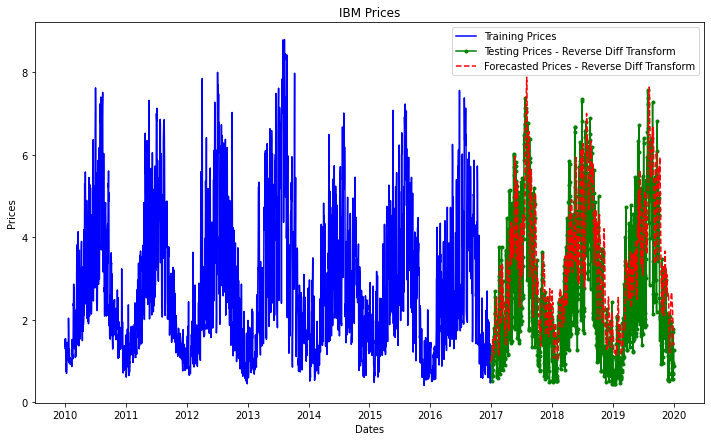

In [34]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

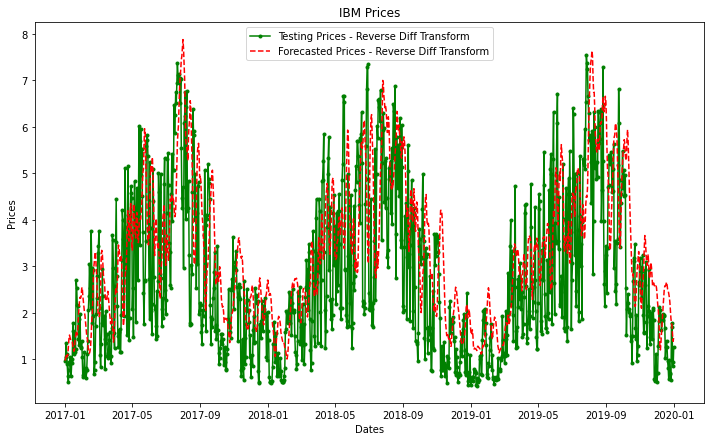

In [35]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_predictions_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

In [36]:
metrics(reverse_test_diff, reverse_predictions)

MAE: 1.25  RMSE: 1.56  R^2: 0.17
